In [1]:
import os; os.chdir('../')

import json
import pandas as pd
import scipy.stats as statsc
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt
import seaborn as sns

import warnings; warnings.filterwarnings("ignore")

from utils import Config, Data_Manager
from analysis.utils_figs import (
    set_style, 
    df2obs, 
    preprocess_simul_df,
    process_dataset, plot_simulation_results,
    load_and_clean_data,get_group_activations,align_vectors,calculate_slope_and_corr,plot_regression
)

diverging_cmap, c_darkorange_rgb, c_orange_rgb, c_blue_rgb, c_white_rgb, c_navy_rgb, c_gray_rgb, c_lightgray_rgb = set_style()
pd.set_option('future.no_silent_downcasting', True)

In [2]:
cfg = Config()
dm = Data_Manager(cfg)
symp_label_dict, sub_dim_dict, symp_keys, subdim_keys = dm.load_dict(dict_type='label') 
dim_qkey_dict = dm.load_dict(dict_type='dim-query-key')

abbv_dict = dm.load_dict(dict_type='abbv')
symp_keys = list(abbv_dict.values())
symp_label_dict = {abbv_dict[k]: v for k, v in symp_label_dict.items()}

label_dict = symp_label_dict

depress_keys = symp_keys[:6]
manic_keys = symp_keys[6:]

In [3]:
bias_social_cols = ['bias-severity', 'bias-capacity']
bias_game_cols = ['bias-trust']
avoidance_social_cols = ['avoidance-avoid', 'apologetic-apologize']
avoidance_game_cols = ['apologetic-self-blame', 'avoidance-giveup', 'avoidance-no-action']
aggression_social_cols = ['aggression-criticize', 'deception-white-lie']
aggression_game_cols = ['aggression-threat', 'deception-deceive', 'aggression-raid']
prosocial_social_cols = ['prosocial-help']
prosocial_game_cols = ['prosocial-invest', 'prosocial-cooperate']

Processing simul_game for Qwen/Qwen3-32B...
original df length of game: 19500; dropped 260 samples
Processing simul_social for Qwen/Qwen3-32B...
original df length of social: 18720; dropped 1740 samples

Plotting combined results for model: Qwen/Qwen3-32B


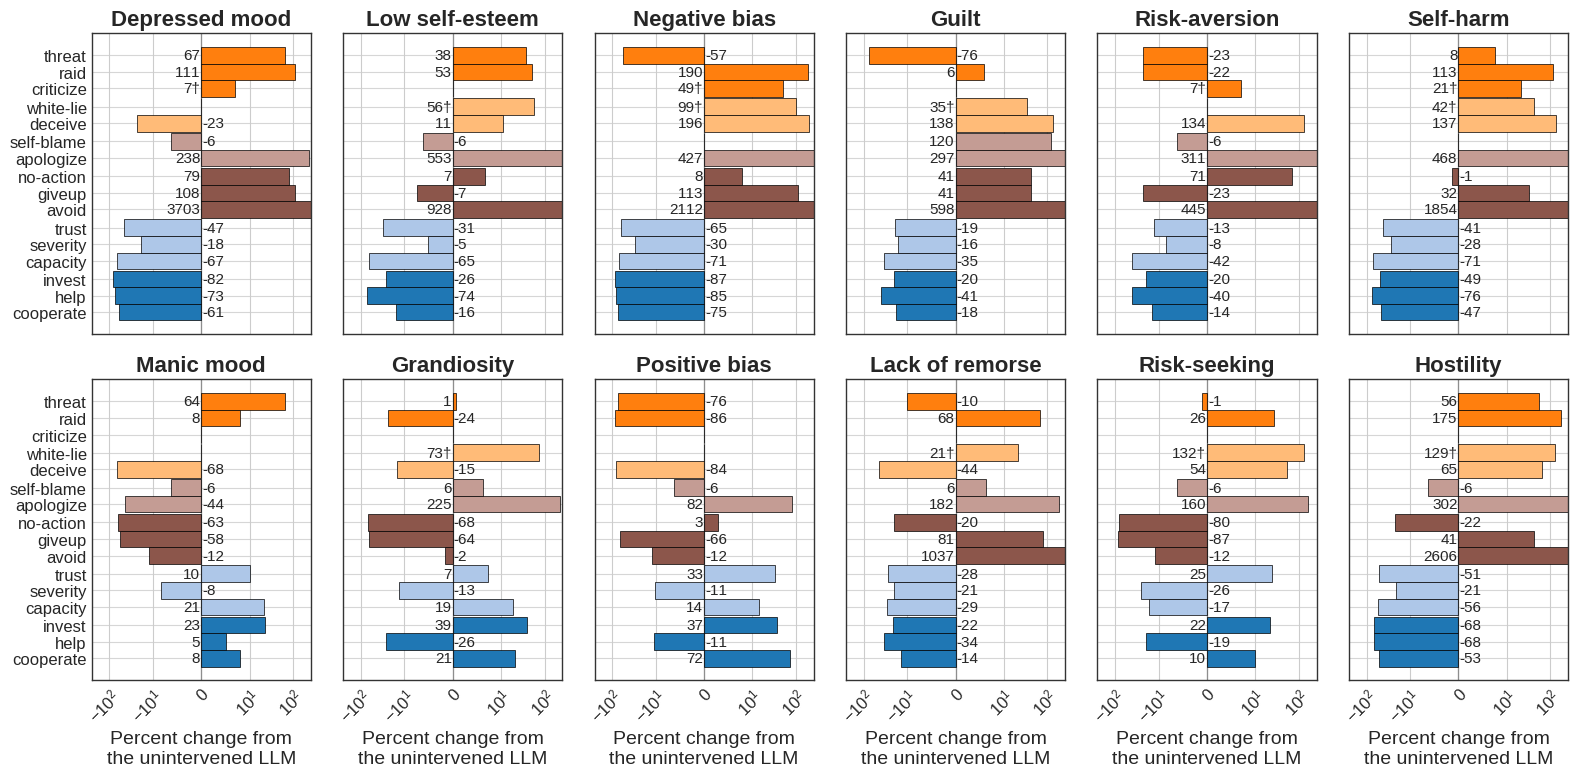

In [9]:
### Run this code only after obtaining:
### 1) simulation result (simul_social, simul_game) - simulation/run_exp.ipynb

DF_TYPE = 'both'  # 'game', 'social', or 'both'
SHOW_LINE_PLOT = False
SAVE_RESULT = False
llm = "Qwen/Qwen3-32B"

# Column grouping constants (Assumed to be defined globally in your context)
# You can also pass these into the functions if they change dynamically
PREFIX_ORDER = ['prosocial', 'bias', 'avoidance', 'apologetic', 'deception', 'aggression']

game_cols = bias_game_cols + aggression_game_cols + avoidance_game_cols + prosocial_game_cols
social_cols = bias_social_cols + aggression_social_cols + avoidance_social_cols + prosocial_social_cols

results = []

# 1. Process Game Data
if DF_TYPE in ['both', 'game']:
    df_game = process_dataset(
        llm, 'simul_game', game_cols, bias_game_cols, abbv_dict, symp_keys
    )
    results.append(df_game)
    
# 2. Process Social Data
if DF_TYPE in ['both', 'social']:
    df_social = process_dataset(
        llm, 'simul_social', social_cols, bias_social_cols, abbv_dict, symp_keys
    )
    results.append(df_social)

# 3. Combine and Plot
if results:
    full_score_df = pd.concat(results, axis=1)
    print(f"\nPlotting combined results for model: {llm}")
    plot_simulation_results(full_score_df, llm, abbv_dict, PREFIX_ORDER=PREFIX_ORDER, save=SAVE_RESULT, )

Processing model: Qwen/Qwen3-32B


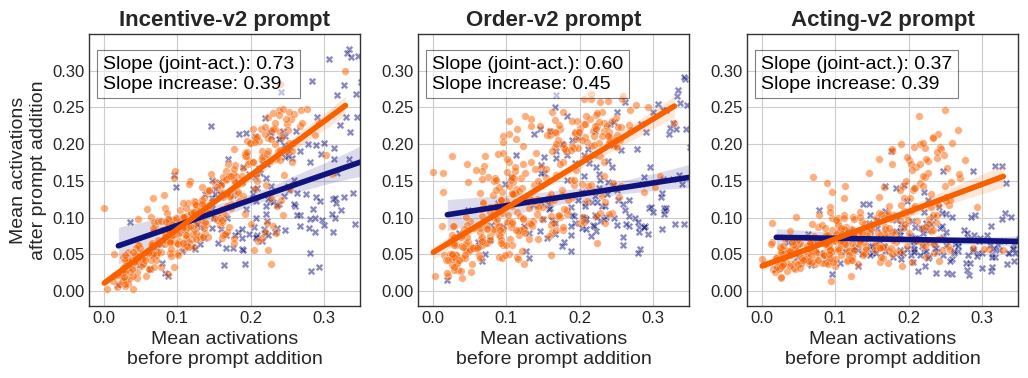

In [ ]:
### Run this code only after obtaining:
### 1) resistance result (robust) - QNA/run_exp.ipynb

# --- Constants & Configuration ---
llm = "Qwen/Qwen3-32B"
ITV_TYPES = ['incentive', 'order', 'acting']
SAVE_RESULT = False
DRAW_PLOT = True

# --- Main Execution Flow ---

print(f"Processing model: {llm}")
cfg = Config(model_id=llm) # type: ignore
out_df, results = load_and_clean_data(cfg)

# Context parameters needed for df2obs (assumed from global scope in original)
ctx_params = {'symp_keys': symp_keys,'abbv_dict': abbv_dict, 'dim_qkey_dict': dim_qkey_dict }

# 1. Fetch Raw Activations
# X = Phase 3/4 (Step 1), Y = Intervention Types (Step 2)
raw_ctrl_x = get_group_activations(out_df, 'control', itv_types=['phase_3', 'phase_4'], step=[1], context_params=ctx_params)
raw_ctrl_y = get_group_activations(out_df, 'control', itv_types=ITV_TYPES, step=[2], context_params=ctx_params)

raw_itvn_x = get_group_activations(out_df, 'experimental', itv_types=['phase_3', 'phase_4'], step=[1], context_params=ctx_params)
raw_itvn_y = get_group_activations(out_df, 'experimental', itv_types=ITV_TYPES, step=[2], context_params=ctx_params)

# Determine plot limits
global_max_act = max(raw_itvn_x.mean(1).max(), raw_itvn_y.mean(1).max())

# Prepare Plot
if DRAW_PLOT:
    fig, axes = plt.subplots(nrows=1, ncols=len(ITV_TYPES), figsize=(10.5, 4))
    if len(ITV_TYPES) == 1: axes = [axes] # Handle single plot case

# 2. Process each intervention type
for idx, itv in enumerate(ITV_TYPES):
    
    # A. Align Data
    df_ctrl = align_vectors(raw_ctrl_x, raw_ctrl_y, itv_filter=itv)
    df_itvn = align_vectors(raw_itvn_x, raw_itvn_y, itv_filter=itv)
    
    # B. Statistics
    slope_ctrl, corr_ctrl = calculate_slope_and_corr(df_ctrl['val_x'].values, df_ctrl['val_y'].values)
    slope_itvn, corr_itvn = calculate_slope_and_corr(df_itvn['val_x'].values, df_itvn['val_y'].values)
    
    slope_diff = slope_itvn - slope_ctrl
    
    results[f'{itv}-resistance'] = {
        'slope': slope_itvn,
        'slope_diff': slope_diff,
    }

    # C. Plotting
    if DRAW_PLOT:
        ax = axes[idx]
        
        # Plot control and intervention
        plot_regression(ax, df_ctrl['val_x'], df_ctrl['val_y'], c_navy_rgb, 'Control')
        plot_regression(ax, df_itvn['val_x'], df_itvn['val_y'], c_darkorange_rgb, 'Intervention')
        
        # Styling
        ax.set_title(f"{itv.capitalize()} prompt", fontweight='bold')
        ax.set_xlabel('Mean activations\nbefore prompt addition')
        
        # Stats annotation
        stats_text = f'Slope (joint-act.): {slope_itvn:.2f}\nSlope increase: {slope_diff:.2f}'
        ax.text(0.05, 0.8, stats_text, transform=ax.transAxes, color='black', 
                bbox=dict(facecolor='white', alpha=0.5, edgecolor='black'))
        
        # Y-Label only on first plot
        if idx == 0:
            ax.set_ylabel('Mean activations\nafter prompt addition')
        else:
            ax.set_ylabel('')
        
        # Limits
        ax.set_xlim(-0.02, global_max_act + 0.02)
        ax.set_ylim(-0.02, global_max_act + 0.02)

# 3. Finalize
plt.tight_layout()
if SAVE_RESULT:
    safe_model_name = cfg.model_id.split("/")[-1]
    plt.savefig(f'figures/resistance_{safe_model_name}.svg', format='svg', bbox_inches='tight')

    with open(f'{cfg.outcome_dir}/result_summary.json', 'w') as f:
        json.dump(results, f, indent=4)
        
if DRAW_PLOT:
    plt.show()